In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from model import BuildingSimulation as bs, BuildingGraph as bg
from model.utils import *
import matplotlib.colors as mcolors
from model.WallSimulation import convectionDOE2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DOE-2 Convection

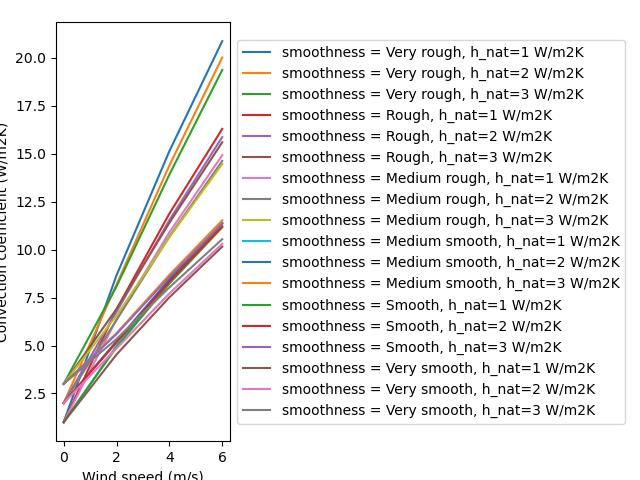

In [15]:
R_f = pd.Series({
    "Very rough": 2.17,
    "Rough": 1.67,
    "Medium rough": 1.52,
    "Medium smooth": 1.13,
    "Smooth": 1.11,
    "Very smooth": 1.00,
})

V = [0, 2, 4, 6]
h_nat = [1, 2, 3]
plt.figure()
for smoothness, r_f in R_f.items():
    for h in h_nat:
        plt.plot(V, convectionDOE2(h, V, r_f), label=f"smoothness = {smoothness}, h_nat={h} W/m2K")
#specify legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#make plot tight
plt.tight_layout()
xlabel = plt.xlabel("Wind speed (m/s)")
ylabel = plt.ylabel("Convection coefficient (W/m2K)")


## Multi Walls

In [19]:
constructions  = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Constructions.csv", index_col="Name")
materials = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Materials.csv", index_col="Name")

In [20]:
wallLayers = ["Outside_Layer", "Layer_2", "Layer_3", "Layer_4", "Layer_5"]
material_df = []
for layer in wallLayers:
    material = constructions[layer]["Light Exterior Wall"]
    if isinstance(material, str):
        conductivity = materials["Conductivity"][material]
        if (conductivity > 10) == False: # filter out the materials with conductivity > 10 that mess up solver and basically transfer all heat
            material_df.append(materials.loc[material])
material_df = pd.DataFrame(material_df)
material_df = material_df.iloc[0:3]
material_df

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
I02 50mm insulation board,Material,MediumRough,0.0508,0.03,43.0,1210.0,NaN
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15
G01a 19mm gypsum board,Material,MediumSmooth,0.0190,0.16,800.0,1090.0,NaN


In [14]:
sim_kwargs = {
    "delt": 10,
    "simLength": 96 * 60 * 60,
    "Tout" : 288.15,
    "radG": 400,
    "Tfloor": None,
}
wall_kwargs = {
    "X": 9,
    "Y": 10,
    "material_df": material_df,
}

room_kwargs = {
    "T0": 293.15,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP1",
    "alphas": None,
    "As": None,
    "Ls": None
}

connectivityMatrix = np.array([
    [3],
])

roomList = [
    ("R", {}), #room
    ]


                                           key     Roughness  Thickness  \
I02 50mm insulation board             Material   MediumRough    0.05080   
F04 Wall air space resistance  Material:AirGap           NaN    0.00698   
G01a 19mm gypsum board                Material  MediumSmooth    0.01900   

                               Conductivity  Density  Specific_Heat  \
I02 50mm insulation board          0.030000     43.0         1210.0   
F04 Wall air space resistance      0.046533     12.0         1005.0   
G01a 19mm gypsum board             0.160000    800.0         1090.0   

                               Thermal_Resistance    depth  
I02 50mm insulation board                     NaN  0.05080  
F04 Wall air space resistance                0.15  0.05778  
G01a 19mm gypsum board                        NaN  0.07678  
maximum time step: 12.626819999999999


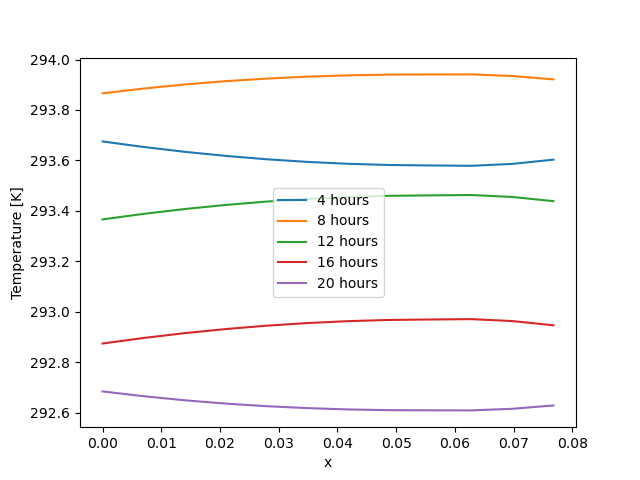

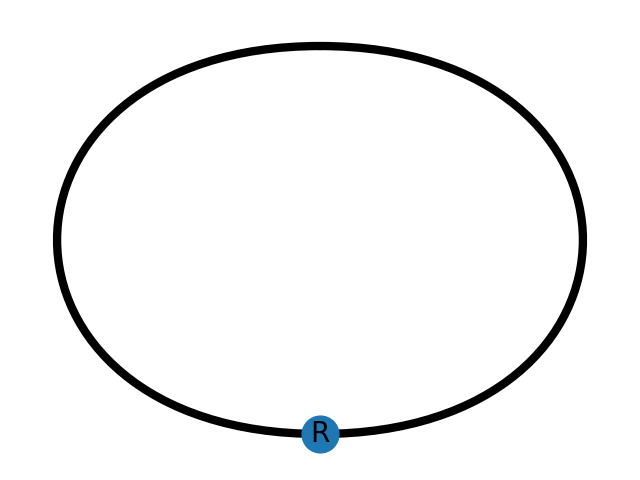

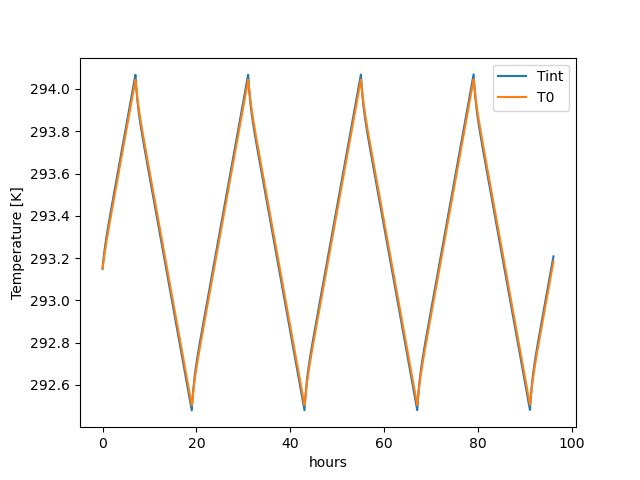

In [15]:
bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.draw()

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
# h_profs = [0, *h_profs]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()